# An Introduction to ML

## The ML Pipeline

* Data organization: Organize the data into vectors of features
* Model selection: What is your question? What is your Loss function
* Feature selection: Also known as model regularization
* Model fitting: Tune the model’s parameters to reduce loss
* Model validation: What is its error? Does it generalize?


In [2]:
import os
import random
import numpy as np
import scipy.optimize as opt
import scipy.stats as stat
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import sklearn as sk
import sklearn.cluster as clust
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
import seaborn as sns
sns.set(style="whitegrid", font="FreeSans")
import pyactup as pau

## Data Organization

All of the examples will use the same dataset, collected in this lab by graduate student Holly Hake. The dataset containss data from 51 elderly adults. The _features_ of the data are age (in years), sex (M or F), and Speed of Foregetting (SoF), a measure of long-term memory function. In addition, each person has been clinically diagnoses as either suffering from Mild Cognitive Impairment (MCI) or being a Healthy Control (HC). 

In [3]:
data = pd.read_csv("holly.csv")
data

,userId,clinicalStatus,age,sex,sof
0,69409,HC,72,F,0.378611
1,69410,HC,58,F,0.364693
2,69411,MCI,75,M,0.441768
3,69412,MCI,70,M,0.467389
4,69414,HC,72,F,0.334343
5,69415,MCI,67,M,0.435315
6,69417,MCI,73,M,0.391745
7,69418,MCI,70,M,0.398536
8,69419,HC,57,F,0.361850
9,69420,HC,73,M,0.364266


We will mostly focus on the _age_ and _SoF_ features. This is what the observations look like when they are plotted across these two dimensions

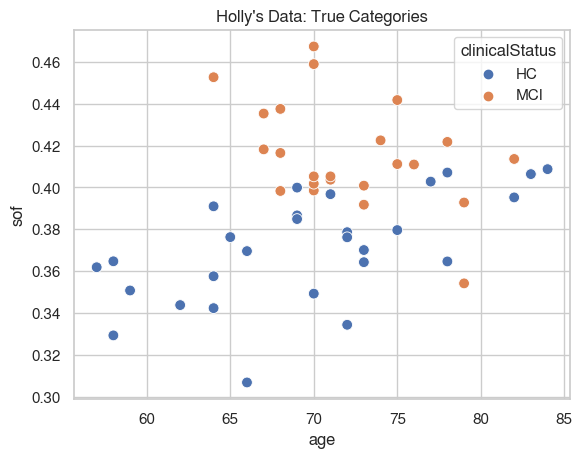

In [4]:
ax = sns.scatterplot(data, x="age", y="sof", hue="clinicalStatus", s=60)
ax.set_title("Holly's Data: True Categories")
plt.show()

# Unsupervised Learning

## Clustering

Suppose we don't _know_ what the true category labels are. Can we make an informed guess?

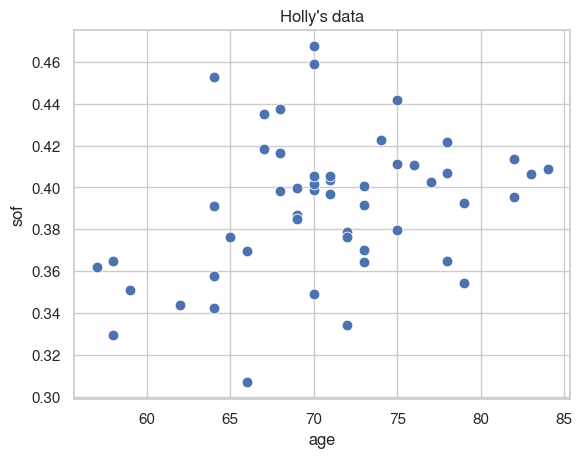

In [5]:
dataX = data[["age","sof"]]
ax = sns.scatterplot(dataX, x="age", y="sof", s=60)
ax.set_title("Holly's data")
plt.show()

One way to do so is to use an algorithm known a _k_ Means clustering. The idea behind _k_-Means is that observations from the same (unknown) class are going to be more similar to each other than observations that are different classes, and that this similarity is going to be relfected in the _Euclidean distances_ between pairs of observations. In this algorithm we start by deciding the value of _k_, that is, how many classes we have, and then:

* Start with _k_ points in random coordinates
   * Each point represents a hypothetical class
* Assign each individual to the class of the closest _k_ point 
   * (like in the Nearest Neighbor method)
* Move the points to the mean coordinates of all the individuals with the same class
   * Hence the name _k_ __means__
   * As a result, some points will now be closer to a different class!
* Repeat until class assignments do not change or a maximum number of iterations has been reached

### The Loss function

Like every ML algorithm, the process of fitting a _k_-Means model involves minimizing a loss function. The iterative procedure above is designed to minimize the mean Euclidean distance between each observation $x$ and the center of its corresponding cluster $c$, which is the sum of the squared difference between the value of each feature $x_f$ and the corresponding feature value of the cluster center:

$$L = \sum_x d(x, c) = \sum_x \sum_f (x_f - c_f)^2 $$

In _k_-Means, this quantity is also called the _inertia_ of the model.

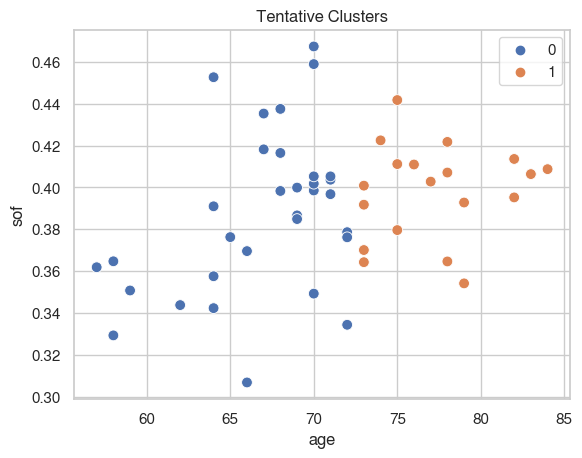

In [6]:
# Create a k-Means model with k=2 clusters
kmeans = clust.KMeans(n_clusters=2, n_init=10).fit(dataX)

# Plot the class assignments
ax = sns.scatterplot(dataX, x="age", y="sof", s=60, hue=kmeans.labels_)
ax.set_title("Tentative Clusters")
plt.show()

Unfortunately, this class assignment is not good. The model has just divided participants based on age, putting them in two groups depending on whether they are younger or older than 72. 

### The importance of scaling your variables

This appens because the variable `age` is on a much larger scale than `sof`. This means that small changes in age will have much larger effects on the Euclidean distance than large changes in `sof`.

To deal with this, we have to scale or _normalize_ the variables. In this case, we will use the _Z_ transformation, scaling each variable by the standard deviation of its distribution:

$$ z_i = \frac{x_i - \bar{x}}{SD_x} $$


In [7]:
dataX['age_zscore'] = (dataX.age - dataX.age.mean()) / dataX.age.std(ddof=0)
dataX['sof_zscore'] = (dataX.sof - dataX.sof.mean()) / dataX.sof.std(ddof=0)
dataZ = dataX[['age_zscore','sof_zscore']]
dataX = dataX[['age','sof']]
dataZ

/tmp/ipykernel_10496/1083979225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['age_zscore'] = (dataX.age - dataX.age.mean()) / dataX.age.std(ddof=0)
/tmp/ipykernel_10496/1083979225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['sof_zscore'] = (dataX.sof - dataX.sof.mean()) / dataX.sof.std(ddof=0)


,age_zscore,sof_zscore
0,0.196421,-0.382386
1,-1.994898,-0.799591
2,0.665989,1.510666
3,-0.116625,2.278641
4,0.196421,-1.709272
5,-0.586193,1.317241
6,0.352943,0.011291
7,-0.116625,0.214844
8,-2.151420,-0.884803
9,0.352943,-0.812363


Now we re-run the _k_ means algorithm with the properly scaled variables:

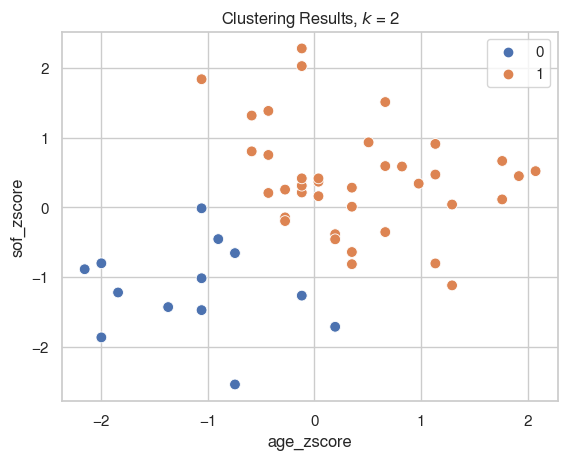

In [8]:
kmeans = clust.KMeans(n_clusters=2, n_init=10).fit(dataZ)
ax = sns.scatterplot(dataZ, x="age_zscore", y="sof_zscore", s=60, hue=kmeans.labels_)
ax.set_title("Clustering Results, $k$ = 2")
plt.show()

The clusters now make, intuitively, much more sense, and the resemble the original class labels. 

### Which value of _k_ should you use?

In the previous case, we have considered _k_ = 2 classes. This was a motivated choice: We _know_ that the data contains two classes of individuals, MCIs and healthy controls, and we want to find a simple way to identify them. In some other cases, however, we might not have any idea of how many classes there really are. Of course, the number of classes we need is arbitrary; the algorithm can handle *any* value of _k_. What would happen if we had 4, instead of 2 classes?

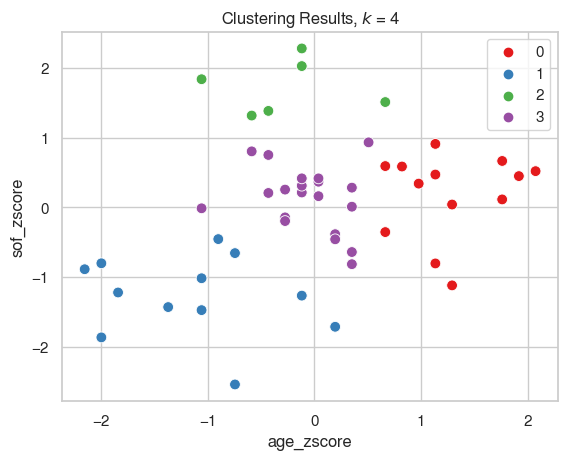

In [9]:
kmeans = clust.KMeans(n_clusters=4, n_init=10).fit(dataZ)
kmeans.labels_

ax = sns.scatterplot(dataZ, x="age_zscore", y="sof_zscore", s=60, hue=kmeans.labels_, palette="Set1")
ax.set_title("Clustering Results, $k$ = 4")
plt.show()

## Evaluating Clusters: The Elbow Method

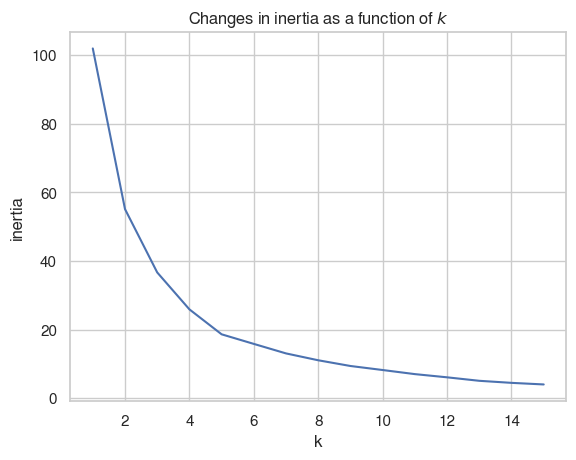

In [10]:
inertias = []
ks = range(1, 16)
for k in ks:
    kmeans = clust.KMeans(n_clusters=k, n_init=10).fit(dataZ)
    inertias.append(kmeans.inertia_)
res = pd.DataFrame(np.array([ks, inertias]).T, columns=['k', 'inertia'])
ax=sns.lineplot(res, x="k", y='inertia')
ax.set_title("Changes in inertia as a function of $k$")
plt.show()

So, it looks like we have two possible "elbows" to choose, one at _k_ = 2 and one at _k_ = 5. We have already seen the the first one; we can now look at the second one: 

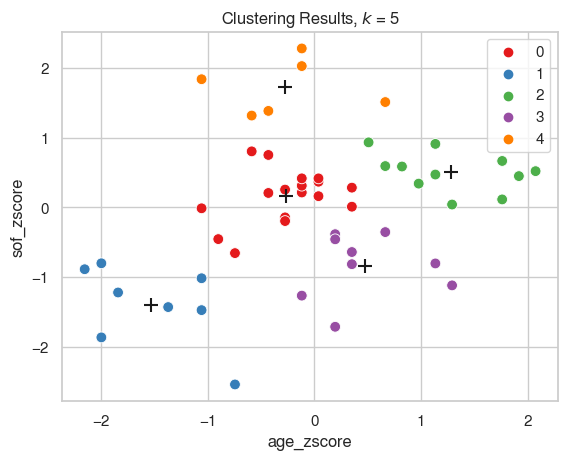

In [11]:
kmeans = clust.KMeans(n_clusters=5, n_init=10).fit(dataZ)

x_centers = [x[0] for x in kmeans.cluster_centers_]
y_centers = [x[1] for x in kmeans.cluster_centers_]

ax = sns.scatterplot(dataZ, x="age_zscore", y="sof_zscore", s=60, hue=kmeans.labels_, palette="Set1")
ax.set_title("Clustering Results, $k$ = 5")
ax.scatter(x_centers, y_centers, marker="+", s=100, color="k")
plt.show()

### Another example: Anais' data

And now, let's look at Anais' data. We have children with different SoF values and different means RTs.

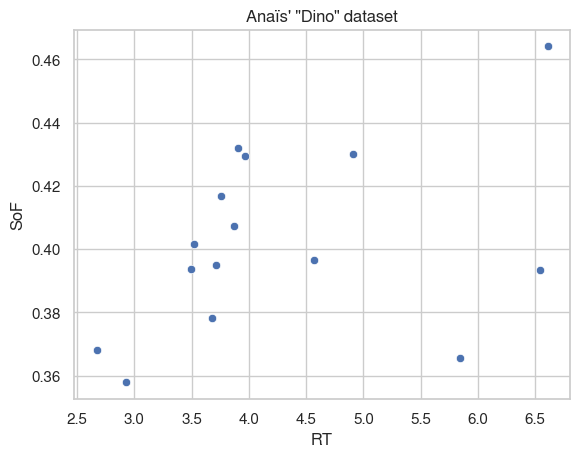

In [12]:
anais = pd.read_csv("anais.csv")
ax = sns.scatterplot(anais, x='RT', y='SoF')
ax.set_title("""Anaïs' "Dino" dataset""")
plt.show()

Let's try with two theoretical classes:

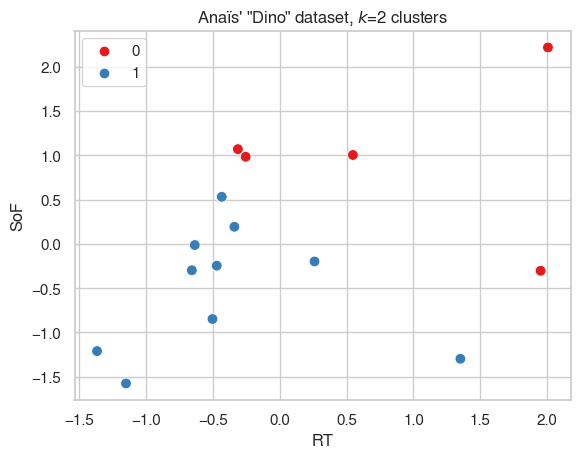

In [13]:
anaisX = anais[['RT', 'SoF']]
z_rt = (anaisX.RT - anaisX.RT.mean()) / anaisX.RT.std(ddof=0)
sof_rt = (anaisX.SoF - anaisX.SoF.mean()) / anaisX.SoF.std(ddof=0)

anaisZ = pd.DataFrame({'RT':z_rt, 'SoF':sof_rt})
kmeans = clust.KMeans(n_clusters=2, n_init=10).fit(anaisZ)
ax = sns.scatterplot(anaisZ, x="RT", y="SoF", s=60, hue=kmeans.labels_, palette="Set1")
ax.set_title("""Anaïs' "Dino" dataset, $k$=2 clusters""")
plt.show()

However, the _ideal_ number of classes would be _k_=5 according to the elbow method

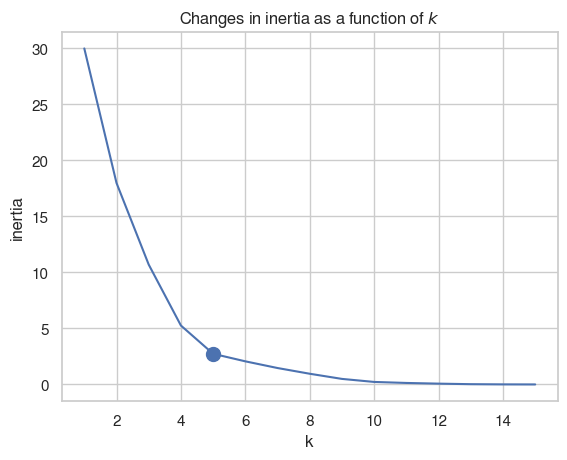

In [14]:

ks = range(1, 16)
inertias=[]
for k in ks:
    kmeans = clust.KMeans(n_clusters=k, n_init=10).fit(anaisZ)
    inertias.append(kmeans.inertia_)
res = pd.DataFrame({'k':ks, 'inertia':inertias})
ax=sns.lineplot(res, x="k", y='inertia')
ax.set_title("Changes in inertia as a function of $k$")
ax.scatter(ks[4], inertias[4], marker='o', s=100)
plt.show()

And precisely these ones:

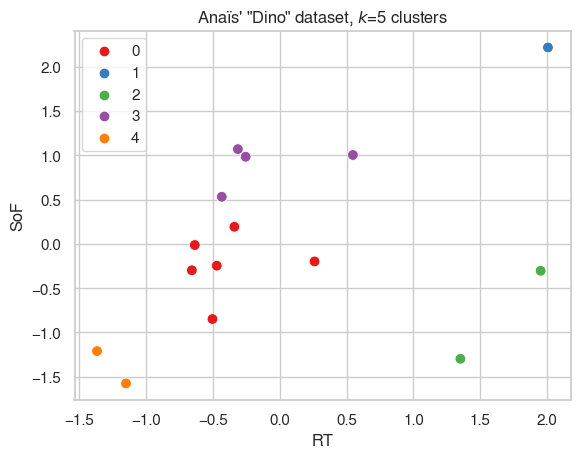

In [15]:
kmeans = clust.KMeans(n_clusters=5, n_init=10).fit(anaisZ)
ax = sns.scatterplot(anaisZ, x="RT", y="SoF", s=60, hue=kmeans.labels_, palette="Set1")
ax.set_title("""Anaïs' "Dino" dataset, $k$=5 clusters""")
plt.show()

# Supervised Learning Methods

Supervised learning methods learn from a set of labelled data, i.e., data for which the ground truth is provided. 

## _k_-Nearest Neighbor (_k_-NN)

Perhaps the simplest classification method is the _k_ nearest neighbor method. You can think of it as the inverse of _k_-Means. 

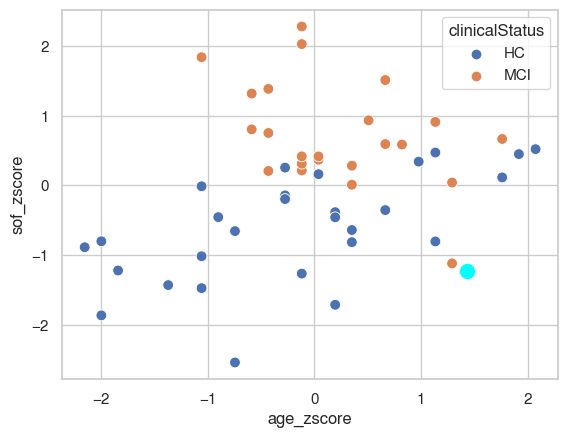

In [16]:
newobs = [80, 0.35]
newobs_z = [(newobs[0] - data.age.mean())/data.age.std(),
            (newobs[1] - data.sof.mean())/data.sof.std()]
x, y = newobs_z
ax=sns.scatterplot(dataZ, x="age_zscore", y="sof_zscore", s=60, hue=data.clinicalStatus)
ax.scatter(x, y, marker="o", color="cyan", s=100)
plt.show()

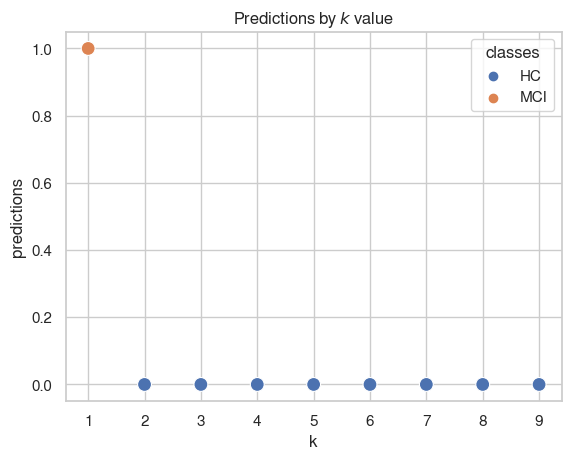

In [17]:
from sklearn.neighbors import KNeighborsClassifier
point = pd.DataFrame({"age":newobs[:-1], "sof":newobs[1:]}) #np.array([newobs]).reshape((1,2))
point_z = pd.DataFrame({"age_zscore":newobs_z[:-1], "sof_zscore":newobs_z[1:]}) #np.array([newobs]).reshape((1,2))
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(dataZ, data.clinicalStatus)
knn.predict(point_z)

ks = range(1, 10)
predictions = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(dataZ, data.clinicalStatus)
    predictions.append(knn.predict(point_z))
    
classes = ([x[0] for x in predictions])
predictions = [0 if x == "HC" else 1 for x in classes]
results = pd.DataFrame({"k":ks, "predictions" : predictions, "classes": classes})
ax = sns.scatterplot(results, x="k", y="predictions", hue="classes", s=100, hue_order=['HC', 'MCI'])
ax.set_title("Predictions by $k$ value")
plt.show()

## Linear Regression

This is the model we are all familiar with from Stats classes. And, yes, it can be used for ML---in fact, it is one of the most common methods!

### The Theory

In linear regression, we are trying to model our data $Y$ as a linear function of our variables $X = {x_1, x_2, ... x_N}$ using a linear function of the form:

$$ Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_N x_N$$

### The Loss function

The loss function in linear regression is the _sum of squares_, i.e., the sum of the squared differences between obsered data _Y_ and the model's predictions _Y*_:

$$ L = \sum_{i=1}^N (Y_i - Y^*_i)^2 $$

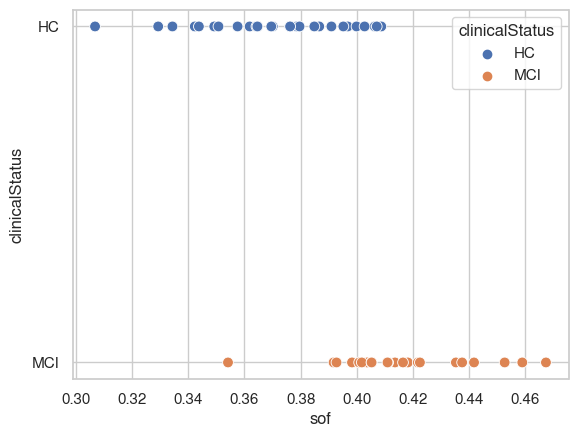

In [18]:
classes = [0 if x == "HC" else 1 for x in data.clinicalStatus ]
ax=sns.scatterplot(data, y="clinicalStatus", x="sof", s=60, hue="clinicalStatus")
plt.show()

first, we need to transform categorical variables as numbers

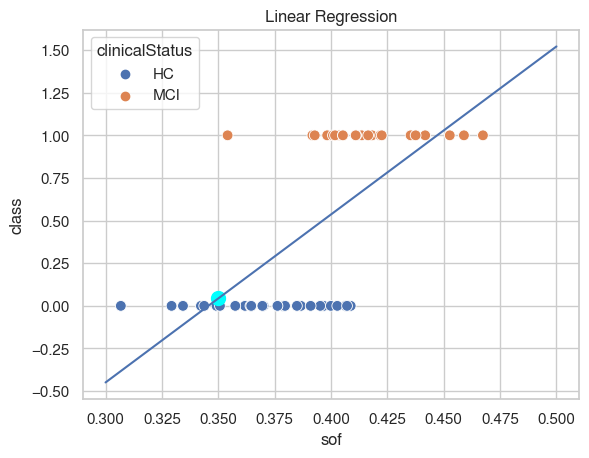

In [19]:
lm = sk.linear_model.LinearRegression()
lm.fit(dataX[['sof']], classes)
data['class'] = classes
ax=sns.scatterplot(data, y="class", x="sof", s=60, hue="clinicalStatus")
b0 = lm.intercept_
b1 = lm.coef_[0]
x = np.linspace(0.3, 0.5)
pred = b0 + b1 * x
ax.plot(x, pred)
ax.set_title("Linear Regression")

xpred = point[['sof']]
ypred = lm.predict(point[['sof']])

ax.scatter(xpred, ypred, s=100, color='cyan') 
plt.show()

And we can see our hypothetical point

## Logistic Regression

Applying Linear Regression can sometimes lead to bizarre results. For example, an individual with an `sof` value of 0.3 would have a predicted `class` value of -0.5; not only this is neither 0 nor 1, but it is actually _outside_ of the range of class values. But even with values that are in-between 0 and 1, how should we interpret them? An individual with an `sof` of 0.4, for example, has a `class` value that just above 0.5; does that mean that the individual has >50% chances of belonging to the MCI class?

Logistic Regression is a method designed to address all of these questions in the case of binary classification problems. Logistic regression works like linear regression, but always returns values between 0 and 1, and these values can always be interpreted as probability of class assignments. 

### The Theory

Logistic regression can be thought as Linear Regression with an extra layer. Like in normal regression, the data is modeled as the sum of of different weighted features. Unlike normal regression, however, this sum does not represent the class values _Y_ directly; rather it represents an intermediate result, _U_:

$$ U = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_N x_N$$

The class data _Y_, instead, is modeled as a logistic function of _W_:

$$ Y = 1 / (1 + e^{U}) $$


### The Loss Function

The loss function is the same as canonical regression, i.e. the sum of squares:

$$ L = \sum_{i=1}^N (Y_i - Y^*_i)^2 $$ 


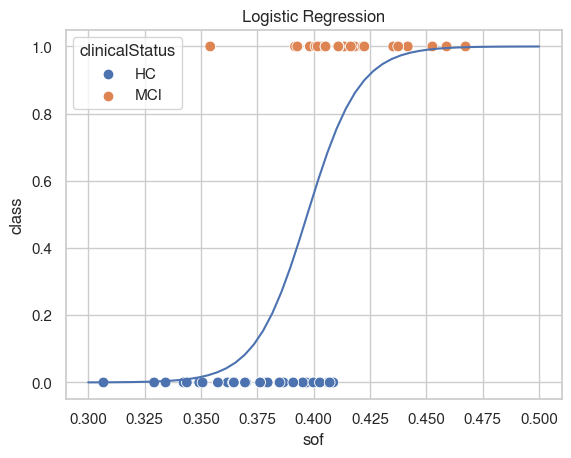

In [25]:
logm = sk.linear_model.LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logm.fit(data[['sof']], classes)

# Create predictions for arbitrary values
newx = pd.DataFrame({'sof':list(np.linspace(0.3, 0.5))})
newy = logm.predict_proba(newx)

ax=sns.scatterplot(data, y="class", x="sof", s=60, hue="clinicalStatus")
ax.plot(newx, newy[:,1])
ax.set_title("Logistic Regression")
plt.show()

# Model Evaluation

How well does a model do? After a model has been _fit_ to the data, its performance can be evaluated against the data itself. 

## Model Fit

"Fit" is the term used to indicate how well the model explains the data it was trained on.


### The Model's Score

Because a model is fit by minimizing its Loss function, the value of the Loss function after fitting is a natural measure of fit. In Python's `scikit-learn` package, This value is stored in the `score` attribute of the fitted model.

### Universal Measure for Classification Accuracy

A model's score is entirely dependent on the specific loss. function 



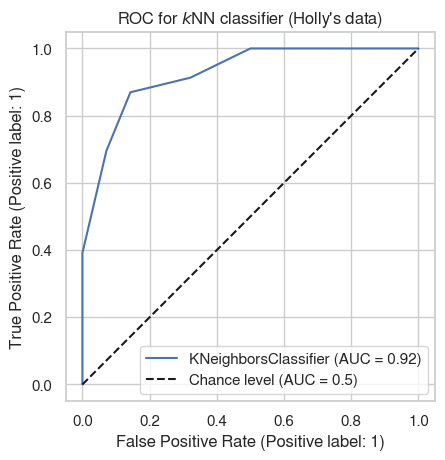

In [21]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(dataZ, classes)
fig, ax = plt.subplots(1)
RocCurveDisplay.from_estimator(knn, dataZ, classes, ax=ax, plot_chance_level=True)
ax.set_aspect('equal')
ax.set_title("ROC for $k$NN classifier (Holly's data)")
plt.show()

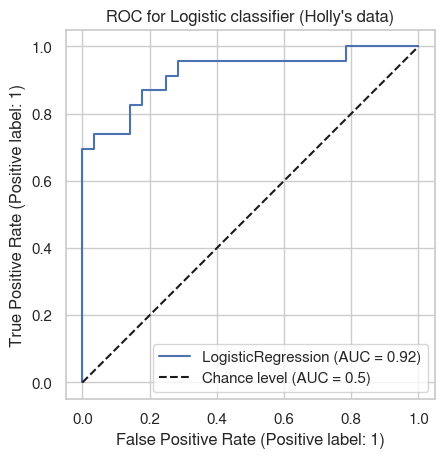

In [22]:
logm = sk.linear_model.LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logm.fit(dataZ, classes)

fig, ax = plt.subplots(1)
RocCurveDisplay.from_estimator(logm, dataZ, classes, ax=ax, plot_chance_level=True)
ax.set_aspect('equal')
ax.set_title("ROC for Logistic classifier (Holly's data)")
plt.show()

## Generalizability

Validating the model against the data itself leads to inflated values. After all, a model should be judged against its ablity to predict _unseen_ data (generalization). This process is called _validation_.

### Validation

The simplest validation method is to split the data into _train_ and _test_ datasets.

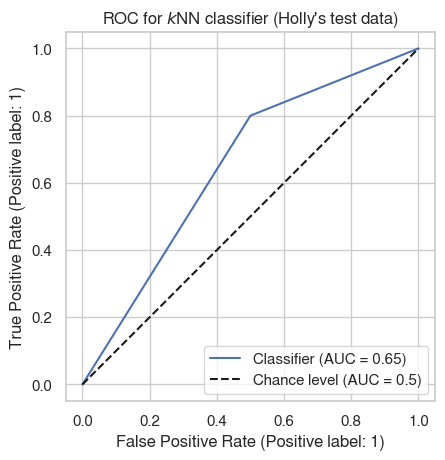

In [23]:
X_train, X_test, y_train, y_test = train_test_split(dataX, classes, random_state=0)
knn.fit(X_train, y_train)
fig, ax = plt.subplots(1)
y_predict = knn.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_predict, ax=ax, pos_label=None, plot_chance_level=True)
ax.set_aspect('equal')
ax.set_title("ROC for $k$NN classifier (Holly's test data)")
plt.show()

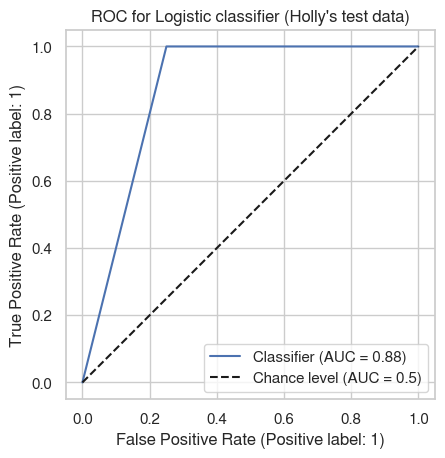

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dataX, classes, random_state=0)
logm.fit(X_train, y_train)
fig, ax = plt.subplots(1)
y_predict = logm.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_predict, ax=ax, pos_label=None, plot_chance_level=True)
ax.set_aspect('equal')
ax.set_title("ROC for Logistic classifier (Holly's test data)")
plt.show()

## Cross-Validation